In [2]:
!pip install pystan

In [3]:
 from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))

Saving My data modified.csv to My data modified (4).csv
User uploaded file "My data modified.csv" with length 35090 bytes


In [0]:
import pystan
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

data = pd.read_csv("My data modified (4).csv", encoding = "latin-1")




In [24]:
prices = []
df_b=data.loc[:, ::2]
df_b=df_b.drop(["Your name"], axis=1)
df_b=df_b.drop(["Neighborhood"], axis=1)

brand_columns = list(df_b)
brands = []
for item in brand_columns:
    brands.append(list(df_b[item][:]))
    
# Flatten list
brands = [item for sublist in brands for item in sublist]

del_indexes_b=[]

# Identify NaN's
for i in range(len(brands)):
    if type(brands[i])!=type("x"):
        del_indexes_b.append(i)
print(len(brands))

# Delete NaN's
for i in del_indexes_b[::-1]:
    del brands[i]


# Transform the brands into either "branded" or not "branded"
# Remove spacing and make everything lowercase
brands = [(''.join(item.split())).lower() for item in brands]
print(brands)
brands_code=[]

# If an item is branded, its code will be 2
counter = 0
for item in brands:
    if item == "nobrand":
        brands_code.append(1)
        counter+=1
    else:
        brands_code.append(2)
print(len(brands_code))
print(counter)

2190
['royalgala', 'honeycrunch', 'royalgala', 'kissedbynature', 'apfelevelina', 'bioorganic', 'grannysmith', 'gutbio', 'rewebestewahl', 'elstar', 'snackapfel', 'pinklady', 'edekagrannysmith', 'fruveg', 'royalgala', 'royalgala', 'nobrand', 'nobrand', 'ambrosia', 'ambrosia', 'looseredapples', 'jemeter', 'bio', 'gutbio', 'pinklady', 'pinklady', 'rotetafelapfel', 'edeka', 'rewe', 'pinklady', 'apfelrotlose', 'pinklady', 'xxljonagoldapfelrot', 'demeter', 'bioorganic', 'rewe', 'talapfelgale', 'apfel', 'braeburn', 'pinklady', 'oaklands', 'oaklands', 'nobrand', 'kanzi', 'nobrand', 'elstar', 'pinklady', 'evalina', 'jonagored', 'pinklady', 'nobrand', 'nobrand', 'pinklady', 'royalgala', 'pinklady', 'evelina', 'pinklady', 'rewebestwahlelstar', 'nobrand', 'rewebio', 'nobrand', 'nobrand', 'bioland', 'reweregional', 'rewebio', 'pinklady', "elstar(ithinkit'snotabrandbutakindofapples)", 'elstar', 'vog', 'funsizeapples', 'pinklady', 'edeka', 'leckerapfel!', 'ambriosa', 'braeburn', 'pinklady', 'pinklady'

In [65]:
import math


zones = list(data["Neighborhood"][:])
categories_z = list(set(zones))
for i in range(len(categories_z)):
    for j in range(len(zones)):
        if categories_z[i] == zones[j]:
            zones[j] = i+1
zones = zones*30
print(categories_z)

stores = list(data["Grocery store brand"][:])
categories_s = list(set(stores))
for i in range(len(categories_s)):
    for j in range(len(stores)):
        if categories_s[i] == stores[j]:
            stores[j] = i+1
stores = stores*30
print(categories_s)


# This leaves us with only the columns that contain prices
prices = []
df_p=data.drop(["Your name"], axis=1)
df_p=df_p.loc[:, ::2]
df_p =df_p.drop(["Grocery store brand"], axis = 1)

price_columns = list(df_p)
prices = []
for item in price_columns:
    prices.append(list(df_p[item][:]))

num_of_products = len(prices)/3
num_of_collectors=len(prices[0])

types=[]
for i in range(int(num_of_products)):
    types.append([i+1]*num_of_collectors*3)
    

    
# Flatten the list of lists into a single list with all prices
prices = [item for sublist in prices for item in sublist]

# Do the same for the types of products
types = [item for sublist in types for item in sublist]
del_indexes = []
for i in range(len(prices)):
    if math.isnan(prices[i]):
        del_indexes.append(i)
        
for i in del_indexes[::-1]:
    del prices[i]
    del zones[i]
    del stores[i]
    del types[i]


['Mitte', 'Alt-Treptow', 'Kreuzberg', 'NeukÃ¶lln', 'London', 'Tempelhof', 'Friedrichshain', 'Lichtenberg', 'Prenzlauer Berg', 'Cape Town', 'SchÃ¶neberg']
['ALDI', 'EDEKA', 'Lidl', 'REWE']


In [0]:
# This should tell us if there are any inconsistencies
# such as a brand without a price or a price without a brand.
for index in del_indexes_b:
    if index not in del_indexes:
        print(index)

for index in del_indexes:
    if index not in del_indexes_b:
        print(index)
        

In [0]:
stan_code = """

// The data block contains all known quantities - typically the observed
// data and any constant hyperparameters.
data {
    int<lower=1> num_items;  // number of items we have
    real<lower=0> prices[num_items];  // list with prices 
    int<lower=0> brands[num_items];  // list with brand of item
    int<lower=0> items[num_items];  // list with type of item
    int<lower=0> stores[num_items];  // list with stores
    int<lower=0> zones[num_items];  // list with zones of stores
    int<lower=1> num_brands;  // number of brands we have
    int<lower=1> num_item;  // number of items we have
    int<lower=1> num_stores;  // number of stores we have
    int<lower=1> num_zones;  // number of zones we have

    
    real<lower=0> alpha; // fixed prior hyperparameter for price (30.0)
    real<lower=0> beta;   // fixed prior hyperparameter
    real prior_multi_mu;  // fixed prior for multipliers mean (1.0)
    real prior_multi_sig;  // fixed prior for multipliers sigma (0.2)
}

// The parameters block contains all unknown quantities - typically the
// parameters of the model. Stan will generate samples from the posterior
// distributions over all parameters.
parameters {
    // We have to make a price parameter for every product
    real<lower=0> p[num_item];   // Gives the base price for a product
    
    // Multiplier for each brand
    real<lower=0> b[num_brands];  // Multiplier depending on the brand. 
                                  // No brand makes it 1. Centered around 1.
                              
    // Multiplier for the store
    real<lower=0> s[num_stores];  // Multiplier depending on the type of store.
                                  // Centered around 1.
    
    //Multiplier for location
    real<lower=0> z[num_zones];  // Multiplier for the zone of the store.
                                 // Centered around 1.
                      
    //For  standard deviation errors
    real<lower=0> e;  // Accounts for random fluctuations
}

// The model block contains all probability distributions in the model.
// This of this as specifying the generative model for the scenario.
model {
    p ~ cauchy(0,alpha);  // prior over price.
    b ~ lognormal(prior_multi_mu,prior_multi_sig);  //prior over brand.
    s ~ lognormal(prior_multi_mu,prior_multi_sig);  //prior over store type.
    z ~ lognormal(prior_multi_mu,prior_multi_sig);  //prior over zone.
    
    e ~ inv_gamma(1,1);
    
    for(i in 1:num_items){
        prices[i] ~ normal(p[items[i]]*b[brands[i]]*s[stores[i]]*z[zones[i]],e);
    }
}

"""

In [0]:
data_ = {
        'num_items':int(len(prices)) ,
        'prices': prices,
        'brands': brands_code,
        'items': types,
        'stores': stores,
        'zones': zones,
    
        'num_brands':len(set(brands_code)),
        'num_item':len(set(types)),
        'num_stores':len(set(stores)),
        'num_zones':len(set(zones)),
    
    
        'alpha':1.0,
        'beta':.01,
        'prior_multi_mu':0,
        'prior_multi_sig':0.25}

In [29]:
# Compile model

stan_model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8cb88f18b2b043862954874352dec35c NOW.
/usr/local/lib/python3.6/dist-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /tmp/tmpzviqqo31/stanfit4anon_model_8cb88f18b2b043862954874352dec35c_2209585151542880277.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [0]:
results = stan_model.sampling(data=data_)

In [0]:
for n, i in enumerate(brand):
    if i == 0:
        brand[n] = 2

In [31]:
print(results.stansummary())

Inference for Stan model: anon_model_8cb88f18b2b043862954874352dec35c.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
p[1]    1.67    0.01   0.35   1.08   1.43   1.63   1.87   2.51    864    1.0
p[2]    1.11  8.0e-3   0.25   0.69   0.94   1.08   1.25   1.69    983    1.0
p[3]    2.66    0.02   0.55   1.72   2.29    2.6   2.97   3.98    857    1.0
p[4]    1.01  7.3e-3   0.23   0.62   0.85   0.99   1.14   1.54    974    1.0
p[5]    0.79  5.7e-3   0.19   0.47   0.66   0.78    0.9   1.22   1096    1.0
p[6]    1.83    0.01   0.39   1.18   1.57   1.79   2.05   2.73    885    1.0
p[7]    0.73  5.4e-3   0.17   0.44   0.61   0.71   0.84   1.13   1066    1.0
p[8]    2.93    0.02    0.6   1.91   2.53   2.86   3.27   4.35    859    1.0
p[9]    1.96    0.01   0.41   1.26   1.68   1.92   2.19   2.93    877    1.0
p[10]   7.98    0.06   1.62   5.21   6.91

In [0]:
items = ["Apples","Bananas","Tomatoes","Potatoes","Flour","Rice",
         "Milk","Butter","Eggs","Chicken Breasts"]

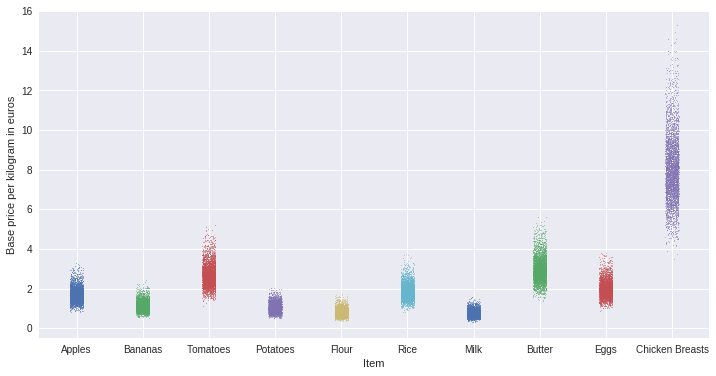

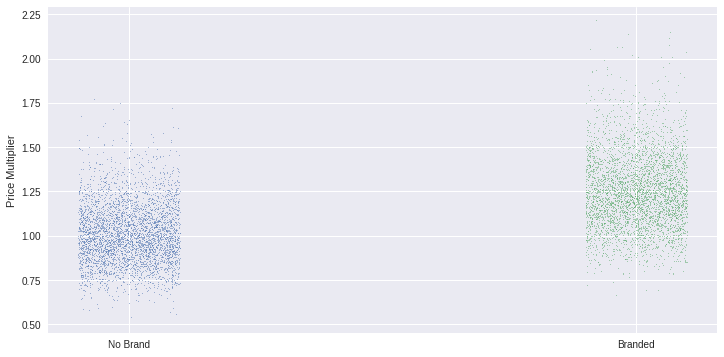

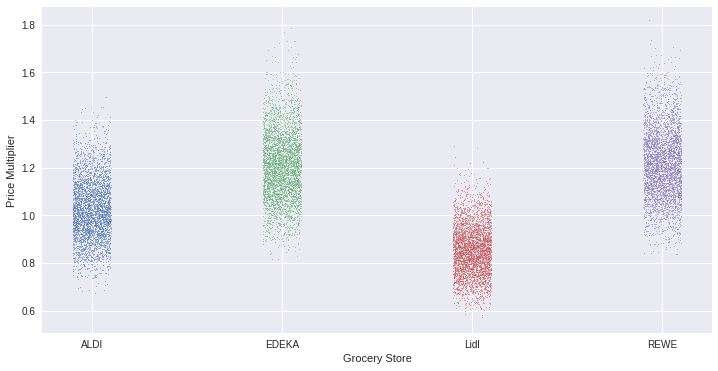

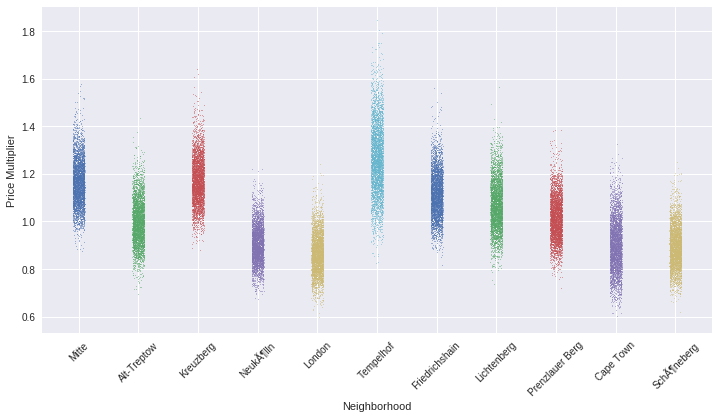

In [64]:
from scipy import stats
samples =results.extract()

plt.figure(figsize=(12,6))
for i in range(10):
    plt.plot(stats.uniform.rvs(loc=i+1-0.1, scale=0.2, size=4000),
             samples['p'][:,i], ',', alpha=0.5)  

plt.ylabel("Base price per kilogram in euros")    
plt.xlabel("Item")
plt.xticks(range(1,11), items)
plt.show()



plt.figure(figsize=(12,6))
for i in range(2):
    plt.plot(stats.uniform.rvs(loc=i+1-0.1, scale=0.2, size=4000),
             samples['b'][:,i], ',', alpha=0.5)
plt.xticks(range(1,3), ["No Brand", "Branded"])
plt.ylabel("Price Multiplier")    
plt.show()  



plt.figure(figsize=(12,6))
for i in range(4):
    plt.plot(stats.uniform.rvs(loc=i+1-0.1, scale=0.2, size=4000),
             samples['s'][:,i], ',', alpha=0.5)
plt.xticks(range(1,5), categories_s)
plt.ylabel("Price Multiplier")    
plt.xlabel("Grocery Store")
plt.show()  



plt.figure(figsize=(12,6))
for i in range(11):
    plt.plot(stats.uniform.rvs(loc=i+1-0.1, scale=0.2, size=4000),
             samples['z'][:,i], ',', alpha=0.5)
plt.xticks(range(1,12), categories_z, rotation=45)
plt.ylabel("Price Multiplier")    
plt.xlabel("Neighborhood")
plt.show()  

Edits to the data:
<br>
+ First row was deleted as it was a duplicate of the 2nd.
+ Row 19 was deleted as the brands of the products were blanks and didn't seem to be submitted as "No brand".
+ The value for row 38 column V was deleted as it didn't have a brand or "no brand" assigned.